# 14.5. Computing the Voronoi diagram of a set of points

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import smopy
%matplotlib inline

In [2]:
df = pd.read_csv('https://github.com/ipython-books/'
                 'cookbook-2nd-data/blob/master/'
                 'ratp.csv?raw=true',
                 sep='#', header=None)

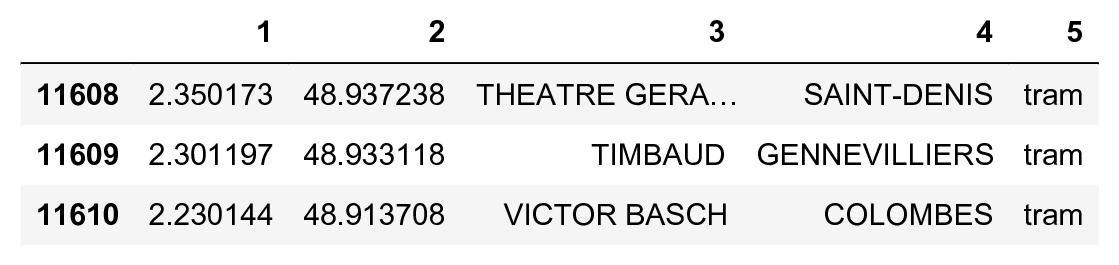

In [3]:
df[df.columns[1:]].tail(3)

In [4]:
metro = df[(df[5] == 'metro')]

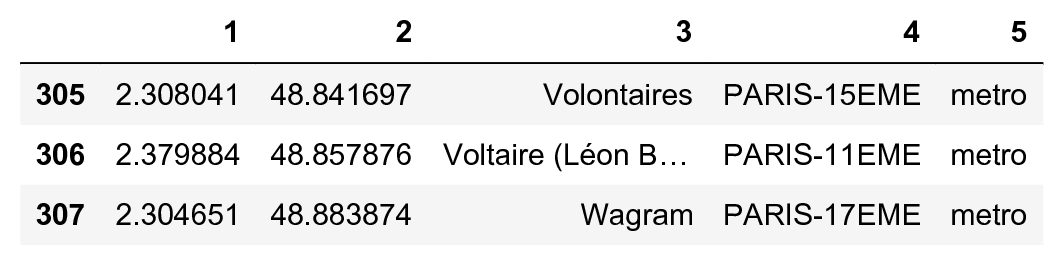

In [5]:
metro[metro.columns[1:]].tail(3)

In [6]:
# We only extract the district from stations in Paris.
paris = metro[4].str.startswith('PARIS').values

In [7]:
# We create a vector of integers with the district
# number of the corresponding station, or 0 if the
# station is not in Paris.
districts = np.zeros(len(paris), dtype=np.int32)
districts[paris] = metro[4][paris].str.slice(6, 8) \
    .astype(np.int32)
districts[~paris] = 0
ndistricts = districts.max() + 1

In [8]:
lon = metro[1]
lat = metro[2]

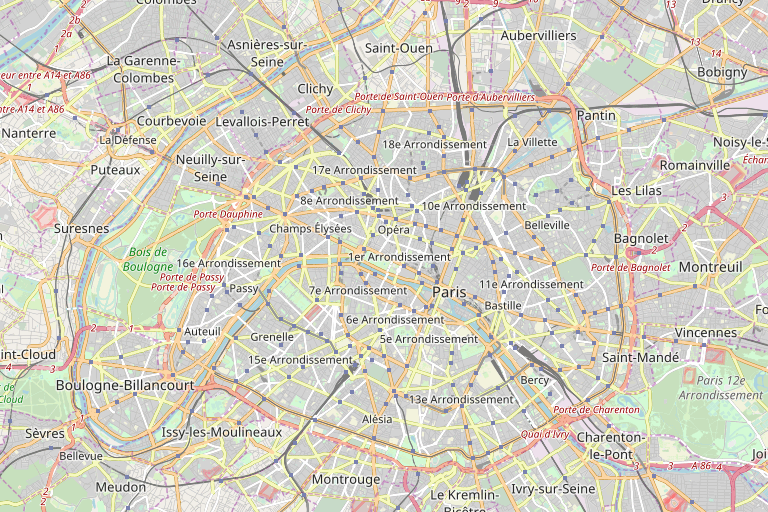

In [9]:
box = (lat[paris].min(), lon[paris].min(),
       lat[paris].max(), lon[paris].max())
m = smopy.Map(box, z=12)
m.show_ipython()

In [10]:
vor = spatial.Voronoi(np.c_[lat, lon])

In [11]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    https://stackoverflow.com/a/20678647/1595060
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [12]:
regions, vertices = voronoi_finite_polygons_2d(vor)

In [13]:
cells = [m.to_pixels(vertices[region])
         for region in regions]

In [14]:
cmap = plt.cm.Set3
# We generate colors for districts using a color map.
colors_districts = cmap(
    np.linspace(0., 1., ndistricts))[:, :3]
# The color of every polygon, grey by default.
colors = .25 * np.ones((len(districts), 3))
# We give each polygon in Paris the color of
# its district.
colors[paris] = colors_districts[districts[paris]]

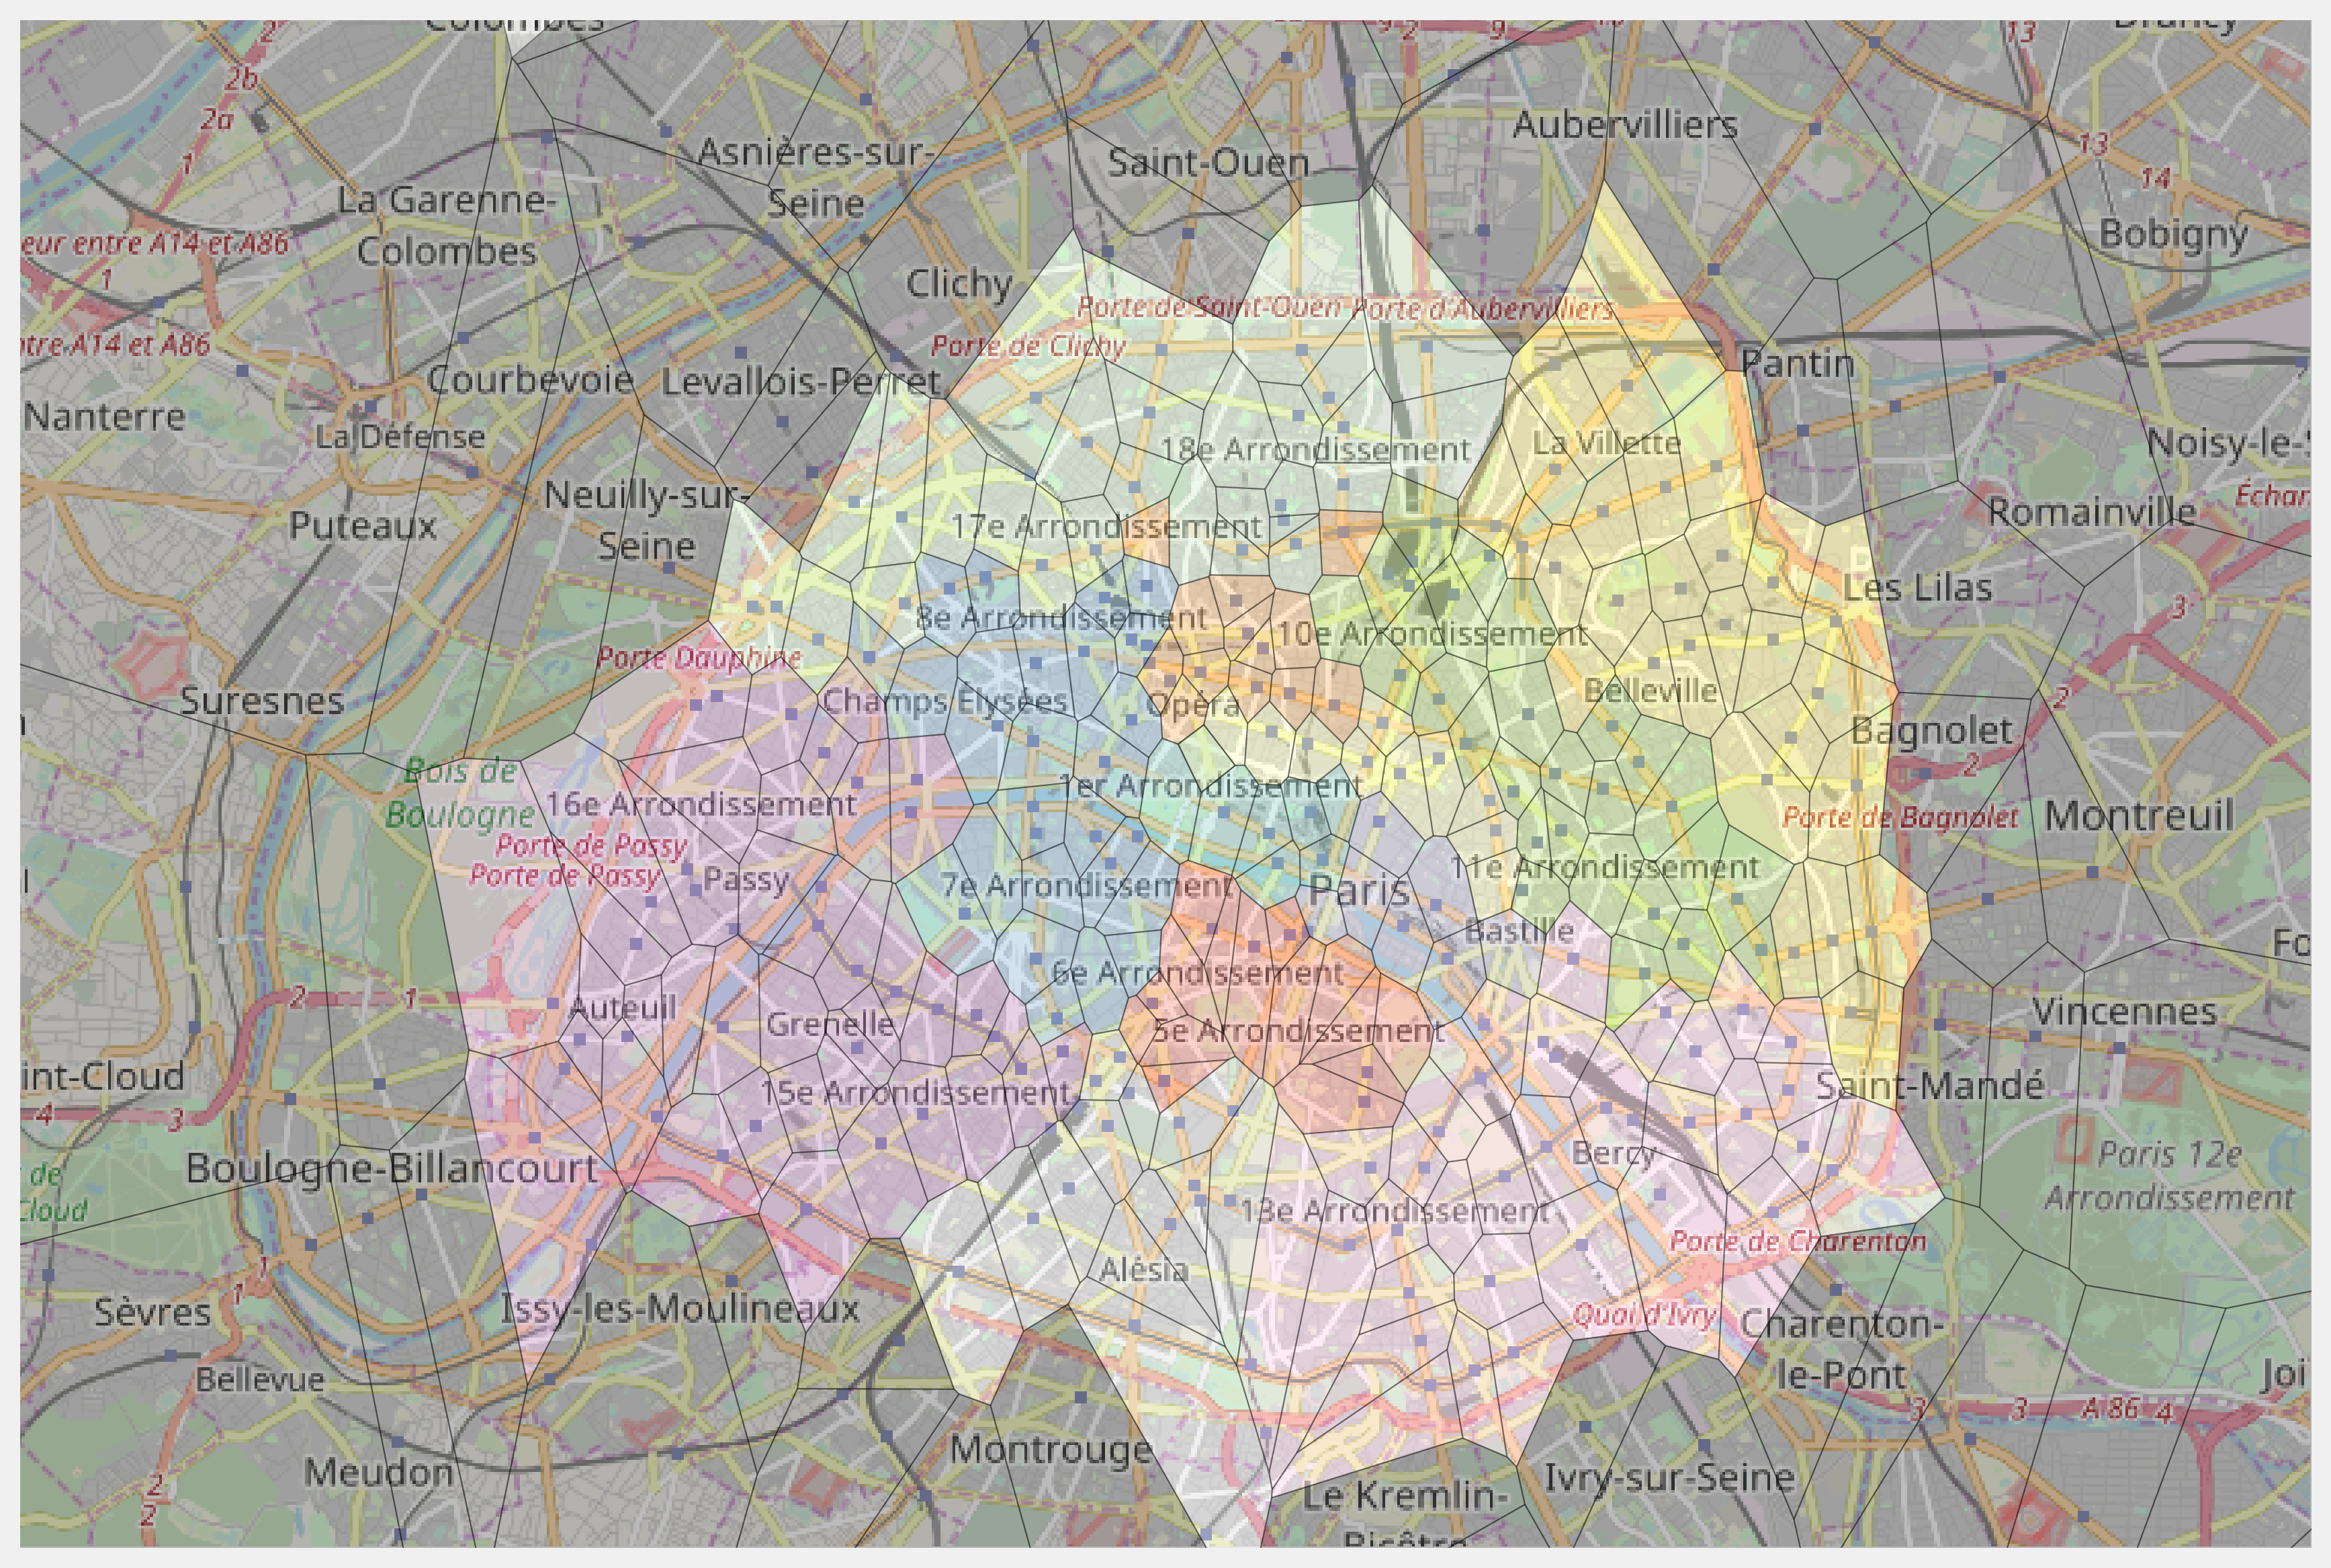

In [15]:
ax = m.show_mpl(figsize=(12, 8))
ax.add_collection(
    mpl.collections.PolyCollection(
        cells, facecolors=colors,
        edgecolors='k', alpha=.35))